In [30]:
import os
import platform
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm
from utils import general_process
import numpy as np
import pickle
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

%matplotlib inline
sns.set_context('notebook')
sns.set_theme(style="ticks", palette="bright")
plt.style.use(['grid'])

# 设置字体
if platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
else:
    plt.rcParams['font.family'] = ['Arial Unicode MS']

# 加载数据
filepath = 'train_data.pkl'
if not os.path.exists(filepath):
    general_process(output_filepath=filepath)
with open(filepath, 'rb') as fin:
    df = pickle.load(fin)

# 验证数据处理是否正确
assert -1 < df.iloc[5242].values[-1][0] + 0.84456 < 1
assert len(df[df['flux_density'].apply(lambda x: np.isnan(x).any()) == True]) == 0

# 筛选附件一材料1中正弦波形的数据
df = df[(df['type_waveform'] == '正弦波') & (df['type_material'] == '1')]
df['flux_density_max'] = df['flux_density'].apply(lambda r: np.max(r))
df

,type_material,temp,freq,core_loss,type_waveform,flux_density,flux_density_max
0,1,25,50030,1997.955250,正弦波,"[0.000212759, 0.000389496, 0.00056608, 0.00074...",0.028849
1,1,25,50020,2427.749830,正弦波,"[-0.000550883, -0.000357918, -0.000165251, 2.7...",0.031419
2,1,25,50020,3332.725760,正弦波,"[-0.003779509, -0.003563773, -0.003348945, -0....",0.035535
3,1,25,50020,4502.908007,正弦波,"[-0.000510932, -0.000266662, -2.25e-05, 0.0002...",0.040015
4,1,25,50030,6063.023248,正弦波,"[0.000457688, 0.000732427, 0.00100655, 0.00128...",0.045028
...,...,...,...,...,...,...,...
1062,1,90,316230,54682.608350,正弦波,"[-0.00042653, -0.000156112, 0.000114214, 0.000...",0.043611
1063,1,90,316230,71443.968180,正弦波,"[-0.001779758, -0.00147584, -0.001172013, -0.0...",0.049015
1064,1,90,316230,94691.425060,正弦波,"[-0.000110836, 0.000230819, 0.000572392, 0.000...",0.055368
1065,1,90,316230,123821.811900,正弦波,"[0.002824627, 0.003208428, 0.003592108, 0.0039...",0.062089


In [62]:
df['temp'].value_counts()

temp
90    275
25    271
70    265
50    256
Name: count, dtype: int64

## 问题二：Steinmetz-equation及其修正

$$y = k_1 * f ^ {\alpha_1} * B ^ {\beta_1}$$


In [2]:
from scipy.optimize import curve_fit


def func_steinmetz(xdata, k1, alpha1, beta1):
    # xdata: array-like, shape (n_samples, 2)
    freq, flux_density_max = xdata
    return k1 * freq ** alpha1 * flux_density_max ** beta1


# xdata: [freq, flux_density_max]
xdata = df[['freq', 'flux_density_max']].values.T

# ydata: core_loss
ydata = df['core_loss'].values

# curve fitting
popt, pcov = curve_fit(func_steinmetz, xdata, ydata)
df['core_loss_steinmetz'] = func_steinmetz(xdata, *popt)

In [3]:
popt

array([1.4997612 , 1.42963345, 2.4712537 ])

In [4]:
df['temp'].unique()

array([25, 50, 70, 90])

25 36833.465225793865 52946.86633283733
50 -225.285718237796 8243.022537533754
70 -15807.95288816936 23140.08120048747
90 -23009.649122149654 30377.918658191014


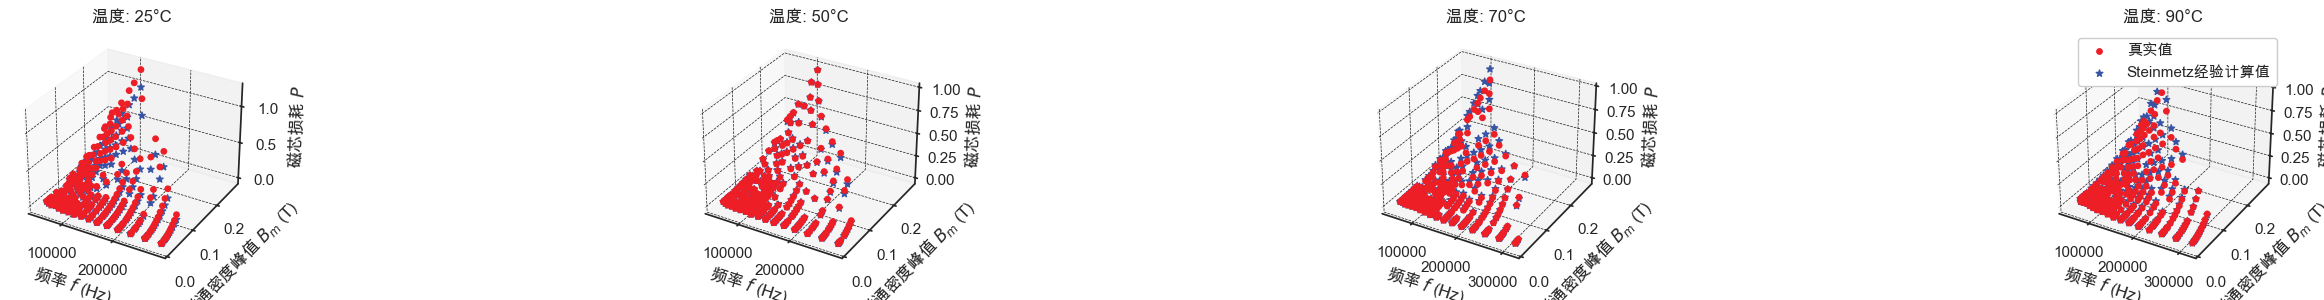

In [5]:
# %matplotlib qt5
fig, axs = plt.subplots(1, 4, figsize=(30, 3),
                        subplot_kw={'projection': '3d'})
temperatures = [25, 50, 70, 90]

for i, temp in enumerate(temperatures):
    ax = axs[i]
    df_temp = df[df['temp'] == temp]
    # plot true values
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss'],
               c='#ed1e25', label='真实值', marker='o', s=15, alpha=1)
    # plot Steinmetz equation predictions
    ax.scatter(df_temp['freq'], df_temp['flux_density_max'], df_temp['core_loss_steinmetz'],
               c='#3753a4', label='Steinmetz经验计算值', marker='*', s=25, alpha=1)
    print(temp,
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).mean(),
          (df_temp['core_loss'] - df_temp['core_loss_steinmetz']).std()
          )
    ax.set_xlabel('频率 $f$ (Hz)')
    ax.set_ylabel('磁通密度峰值 $B_{m}$ (T)')
    ax.set_zlabel('磁芯损耗 $P$')
    ax.set_title(f'温度: {temp}°C')
plt.legend()
plt.tight_layout()
plt.show()

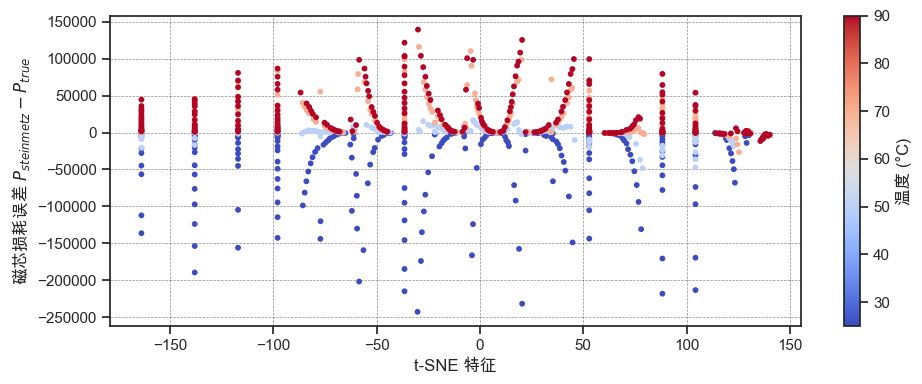

In [85]:
# t-sne
from sklearn.manifold import TSNE

features = df[['freq', 'flux_density_max']].values
tsne = TSNE(n_components=1, random_state=42)
tsne_features = tsne.fit_transform(features)
df['tsne'] = tsne_features
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df['tsne'], df['core_loss_steinmetz'] - df['core_loss'],
            c=df['temp'], cmap='coolwarm', s=10)
plt.colorbar(label='温度 (°C)')
plt.xlabel('t-SNE 特征')
plt.ylabel('磁芯损耗误差 $P_{steinmetz} - P_{true}$')
plt.tight_layout()
plt.savefig('figures/p2-2d-Steinmetzse-tsne.pdf', bbox_inches='tight')

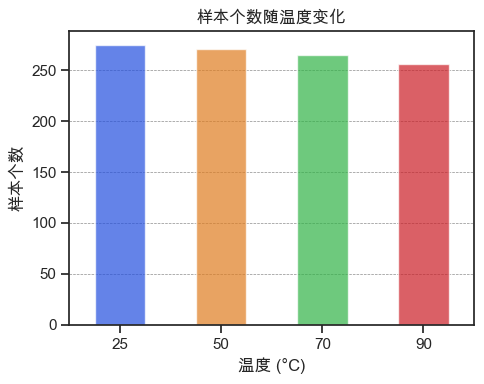

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.barplot(x=df['temp'].unique(),
            y=df['temp'].value_counts(), width=.5, ax=ax, alpha=0.7)
ax.set_ylabel("样本个数")
ax.set_xlabel("温度 (°C)")
ax.set_title("样本个数随温度变化")
plt.tight_layout()
plt.savefig('figures/p2-Steinmetzse-analysis(1).pdf', bbox_inches='tight')

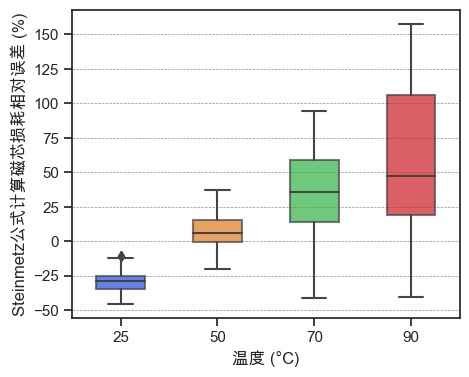

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
df['relative_error'] = ((df['core_loss_steinmetz'] - df['core_loss']) / df['core_loss']) * 100
sns.boxplot(data=df,
            x="temp",
            y="relative_error",
            width=.5, ax=ax,
            boxprops=dict(alpha=.7))
ax.set_ylabel("Steinmetz公式计算磁芯损耗相对误差 (%)")
ax.set_xlabel("温度 (°C)")
plt.savefig('figures/p2-Steinmetzse-analysis(2).pdf', bbox_inches='tight')

## 尝试: 参数拟合

Steinmetz & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta}$ \\
Proportional & $P = c \cdot k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot T$ \\
Linear & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot \left(c \cdot T + d\right)$ \\
Quadratic & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot \left(c_{1} \cdot T^{2} + c_{2} \cdot T + d\right)$ \\
Reciprocal & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot \left(T^{-1}\right)^{c}$ \\
Polynomial & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot \left(c_{1} \cdot T^{-1} + c_{2} \cdot T + d\right)$ \\
Exponential & $P = k \cdot f^{\alpha} \cdot B_{m}^{\beta} \cdot e^{c \cdot T}$ \\
Steinmetz & $P = 1.5 \cdot f^{1.43} \cdot B_{m}^{2.471}$ \\
Proportional & $P = 0.007303 \cdot f^{1.537} \cdot B_{m}^{2.617} \cdot T$ \\
Linear & $P = 2014.0 \cdot f^{1.439} \cdot B_{m}^{2.432} \cdot \left(0.0009289 - 5.032 \cdot 10^{-6} \cdot T\right)$ \\
Quadratic & $P = 1222.0 \cdot f^{1.467} \cdot B_{m}^{2.451} \cdot \left(0.001405 - 1.744 \cdot 10^{-5} \c

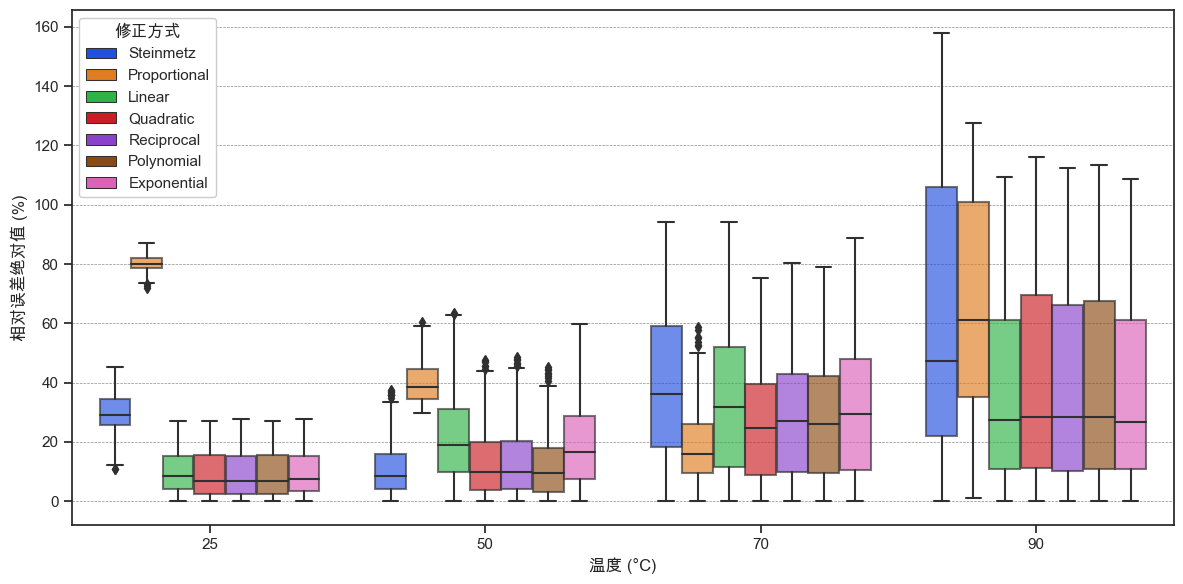

In [125]:
from sklearn.metrics import r2_score
# use scipy to simplify function definition process and support Latex output
import sympy as sp
from sympy import symbols, exp, log, latex
from sympy.utilities.lambdify import lambdify

freq, flux_density_max, temp = symbols('f B_m T', commutative=False)
k, alpha, beta, c, d, k1, k2, c1, c2 = symbols('k alpha beta c d k1 k2 c1 c2')


def def2numerical(function_definitions):
    numerical_functions = {}
    for name, expr, params in function_definitions:
        # create a lambda function for numerical computation
        func_num = lambdify(
            (freq, flux_density_max, temp, *params),
            expr,
            modules=['numpy']
        )
        # define a wrapper function for curve_fit

        def func_wrapper(xdata, *args, func_num=func_num):
            freq_data, flux_density_max_data, temp_data = xdata
            return func_num(freq_data, flux_density_max_data, temp_data, *args)
        numerical_functions[name] = (func_wrapper, params)
    return numerical_functions


function_definitions = [
    ('Steinmetz', k * freq**alpha * flux_density_max**beta + 0 * temp, [k, alpha, beta]),
    ('Proportional', k * freq**alpha * flux_density_max**beta * (c * temp), [k, alpha, beta, c]),
    ('Linear', k * freq**alpha * flux_density_max**beta * (c * temp + d), [k, alpha, beta, c, d]),
    ('Quadratic', k * freq**alpha * flux_density_max**beta * (c1 * temp**2 + c2 * temp + d), [k, alpha, beta, c1, c2, d]),
    ('Reciprocal', k * freq**alpha * flux_density_max**beta * (1 / temp)**c, [k, alpha, beta, c]),
    ('Polynomial', k * freq**alpha * flux_density_max**beta * (c1 * temp**(-1) + d + c2 * temp), [k, alpha, beta, c1, c2, d]),
    ('Exponential', k * freq**alpha * flux_density_max**beta * exp(c * temp), [k, alpha, beta, c]),
    # ('Sigmoid', k * freq**alpha * flux_density_max**beta / (1 + exp(-(c * temp + d))), [k, alpha, beta, c, d]),
]

numerical_functions = def2numerical(function_definitions)

for name, (expr, params) in zip(numerical_functions.keys(), [item[1:] for item in function_definitions]):
    # print the function with parameters if fitting failed
    latex_expr = latex(expr, mul_symbol=' \cdot ')
    print(f"{name} & $P = {latex_expr}$ \\\\")

xdata = df[['freq', 'flux_density_max', 'temp']].values.T
ydata = df['core_loss'].values

popt_values = {}
eval_metrics = ['R2', 'MSE', 'RMSE', 'MAE']
scores = {metric: {} for metric in eval_metrics}

for name, (func, params) in numerical_functions.items():
    try:
        xxdata = xdata
        p0 = [1.0, 2, 2.5] + [0.0] * (len(params) - 3)
        popt, _ = curve_fit(func, xxdata, ydata, p0=p0, maxfev=10000)
        popt_values[name] = popt
        df[f'core_loss_{name.lower()}'] = func(xxdata, *popt)
        df[f'relative_error_{name.lower()}'] = (np.abs(df['core_loss'] - df[f'core_loss_{name.lower()}']) / df['core_loss']) * 100

        # Calculate evaluation metrics
        scores['R2'][name] = r2_score(ydata, df[f'core_loss_{name.lower()}'])
        scores['MSE'][name] = np.mean((ydata - df[f'core_loss_{name.lower()}'])**2)
        scores['RMSE'][name] = np.sqrt(scores['MSE'][name])
        scores['MAE'][name] = np.mean(np.abs(ydata - df[f'core_loss_{name.lower()}']))
    except Exception as e:
        print(f"Failed to fit {name} function: {str(e)}")

for name, (expr, params) in zip(numerical_functions.keys(), [item[1:] for item in function_definitions]):
    popt = popt_values.get(name)
    if popt is not None:
        # create a dictionary of parameter substitutions
        param_subs = dict(zip(params, popt))
        # substitute numerical values into the symbolic expression
        expr_subs = expr.subs(param_subs)
        # round numerical values to four decimal places
        expr_subs = expr_subs.evalf(4)
        # generate LaTeX expression
        latex_expr = latex(expr_subs, mul_symbol=' \cdot ')
        print(f"{name} & $P = {latex_expr}$ \\\\")

# create a new dataframe for plotting
plot_df = pd.DataFrame()
for name, (func, params) in numerical_functions.items():
    temp_df = df[['temp', f'relative_error_{name.lower()}']].copy()
    temp_df['Function'] = name
    temp_df.rename(columns={f'relative_error_{name.lower()}': 'Relative Error'}, inplace=True)
    temp_df['R2'] = scores['R2'][name]
    temp_df['MSE'] = scores['MSE'][name]
    temp_df['RMSE'] = scores['RMSE'][name]
    temp_df['MAE'] = scores['MAE'][name]
    plot_df = pd.concat([plot_df, temp_df], ignore_index=True)

# create a dataframe for LaTeX table
latex_df = pd.DataFrame(scores)

# find the minimum error values and mark them with bold and asterisk
for metric in eval_metrics:
    value = latex_df[metric].min()
    if metric == 'R2':
        value = latex_df[metric].max()
    latex_df[metric] = latex_df[metric].apply(lambda x: f"\\textbf{{{x:.4f}}}*" if x == value else f"{x:.4f}")

# plot boxplot with hue as different functions
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='temp', y='Relative Error', hue='Function', boxprops=dict(alpha=.65))
plt.ylabel("相对误差绝对值 (%)")
plt.xlabel("温度 (°C)")
plt.legend(title='修正方式')
plt.tight_layout()
plt.savefig('figures/p2-modified-final.pdf', bbox_inches='tight')

In [120]:
latex_table = latex_df.to_latex(index=True, caption='Evaluation Metrics for Different Functions')
print(latex_table)

\begin{table}
\caption{Evaluation Metrics for Different Functions}
\begin{tabular}{lllll}
\toprule
 & R2 & MSE & RMSE & MAE \\
\midrule
Steinmetz & 0.9448 & 1638190471.6413 & 40474.5657 & 20615.5354 \\
Proportional & 0.6086 & 11614128696.8673 & 107768.8670 & 47299.1696 \\
Linear & 0.9908 & 273567131.1735 & 16539.8649 & 9717.0630 \\
Quadratic & \textbf{0.9955}* & \textbf{134806625.2394}* & \textbf{11610.6255}* & 6775.1744 \\
Reciprocal & 0.9953 & 138596508.8063 & 11772.7018 & 6850.9860 \\
Polynomial & 0.9954 & 136177397.7051 & 11669.5072 & \textbf{6762.2080}* \\
Exponential & 0.9929 & 211145205.5796 & 14530.8364 & 8435.1055 \\
\bottomrule
\end{tabular}
\end{table}

